# Recommendation algorithms in Python

In this lab, we will implement different recommendation algorithms and evaluate their performance on a movie rating prediction task.

**Task 1:** First, we will build a simple item-based kNN recommendation algorithm with different item feature representations. We will verify the outputs on a small dataset of movie ratings.

**Task 2:** Next, we will use the `surprise` Python package with different collaborative filtering recommendation algorithm implementations and compare their performance for different hyperparametes setting on a standard movie ratings dataset. 

In [56]:
import urllib.request
import pandas as pd
import numpy as np
import zipfile
import os
import datetime

## Task 1: Item-based kNN recommendations with different item representations

First, we wil implement an item-based approach to recommendations based on k Nearest Neighbors (kNN) model. We will evaluate it on the rating prediction task for a small sample of movies dataset.

### Read the data
We use a small version of the popular MovieLens movie recommendation dataset from GroupLens https://grouplens.org/datasets/movielens/

In [57]:
data_url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
urllib.request.urlretrieve(data_url, 'movielens.zip')
movies_file = zipfile.ZipFile('movielens.zip')
data_filename = 'ml-latest-small'

ratings = pd.read_csv(movies_file.open('ml-latest-small/ratings.csv'))
movies = pd.read_csv(movies_file.open('ml-latest-small/movies.csv'))

### Exploratory data analysis 
First, we perform an exploratory analysis to learn basic characteristics of the dataset.

In [58]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


What is the rating time distribution?

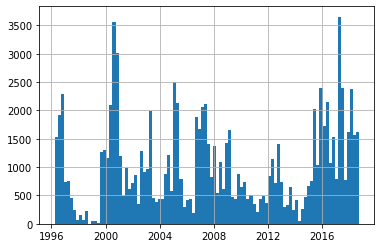

In [59]:
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['datetime'].hist(bins=100)

What is the rating values distribution?

In [60]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

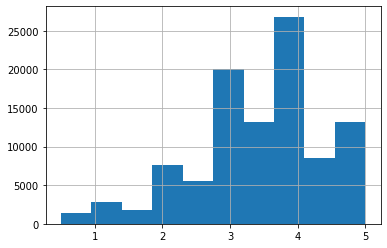

In [61]:
ratings.rating.hist(bins=10)

We can observe that each user has rated relatively few movies - the rating matrix is sparse which is a significant problem for the recommendation systems.

In [62]:
ratings.groupby('movieId').count()['rating'].describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64

In [63]:
ratings.groupby('userId').count()['rating'].describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

### Predicting the user-item ratings
We will implement an item-based k-nearest neighbors (kNN) recommendation algorithm. We will predict the user-movie ratings based on the user's ratings of the most similar movies.

### Train test split

Usually in ML tasks, the train test split is performed at random. However, in real-world recommendation systems, the training is usually perfomed on historical data while the system needs to run in the following period of time. We will use the time split instead of random split for selecting the test set.

In this task, we use only the movies and users that are available in both training and test data. Predicting the ratings of new users and items is known as the *cold-start problem* for recommendation systems and it's beyond the scope of this lab.

 <font color='red'>**ToDo:**</font>
- Split the dataset to train and test sets by the rating time. Select the date to split such that the train/test split ratio is around 80/20%.

    Hint: you may use `df[column].describe(percentiles=[...])` method to get the percentiles for the rating timestamp, docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html

In [ ]:
split_ts = ??

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)
# we consider only the movies and users that are available in both training and test set 
# and only the movies with a record in metadata table.
train_users = train_ratings.groupby('userId').count().reset_index()[['userId']]
train_movies = train_ratings.groupby('movieId').count().reset_index()[['movieId']].merge(movies[['movieId']], on='movieId')
movies = movies.merge(train_movies, on='movieId')
test_ratings = ratings[ratings['timestamp'] > split_ts].merge(train_users, on='userId').merge(train_movies, on='movieId')

In [ ]:
print(train_ratings.count() / ratings.count())

### Build a user-movie rating matrix
First, we will construct the rating matrix $R$. Note that our rating matrix is sparse (there are many empty values) - as for now, we leave the empty values as NaNs. In this exercise we use a small dataset but for larger ones it is more efficient to use a sparse matrix instead of the dense one (we use a dense matrix due to better readability).

<font color='red'>**ToDo:**</font>
- Construct a pivot table with user ids as columns, movie ids as index and user-movie ratings as values. 

Hint: 
You may use `df.pivot_table(index=..., columns=..., values=...)` https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

In [ ]:
rating_mx = ??
rating_mx.head()

### Calculate the baseline predictions

First, we need to define some baseline approaches for our recommendation algorithms and define the evaluation metric. We will use the  mean square error (MSE) between the true and predicted ratings.

The simplest baseline algorithm for rating prediction is an average rating for all movies.

<font color='red'>**ToDo:**</font>
- Prepare a new vector with predictions for each of the test ratings and fill it with mean value of all ratings.

In [ ]:
avg_rating = ??
pred_avg = ??

<font color='red'>**ToDo:**</font>
- Calculate `mean_squared_error` between the test set ratings and predictions: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [ ]:
mse_avg = ??
print(mse_avg)

### Item-based kNN recommendations
We will use the item-based kNN recommender - we will estimate the ratings for a new movie based on the ratings of similar movies in the user's history. We will define the similarity between movies for different movie representations.

As the similarity measure, we use pairwise cosine similarity between movie feature vectors. This measure is more robust to sparse vectors than the Euclidean distance. We will calculate the similarity matrix for all movies pairs according to this metric.

We define two help functions for retrieving the most similar movies to selected one based on the similarity matrix and predicting the user-item rating based on the user's ratings on the most simliar movies in their history.

In [ ]:
def get_similar_movies(movie_id, similarity_df, n_neighbors=5):
    similar_ids = similarity_df.loc[movie_id].sort_values(ascending=False)[1:n_neighbors+1].reset_index()
    return similar_ids.merge(movies, on='movieId')[['title', 'genres']]

In [ ]:
def get_item_knn_rating(user_id, movie_id, movie_similarity, n_neighbors=5):
    user_ratings = rating_mx[user_id].dropna()
    neighbors_rated = movie_similarity.loc[user_ratings.index][movie_id].sort_values(ascending=False)[:n_neighbors]
    predicted_rating = user_ratings.loc[neighbors_rated.index].mean()
    return predicted_rating

We select an exemplary movie for a qualitative evaluation of different methods.

In [ ]:
test_movie = movies.iloc[0]
test_movie

#### KNN Content-Based Recommendations

As the first approach, we use the content-based features of movies to calculate their similarity - in this case these are the movie genres.

In [ ]:
movies.head()

 <font color='red'>**ToDo:**</font>
- Use sklearn `CountVectorizer`  to build the content-based the movies features matrix from their genres https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html.
- Split the lists of genres with | separator (use argument `token_pattern='[^|]+'` for `CountVectorizer`)



In [ ]:
vectorizer = ??
content_features = pd.DataFrame(vectorizer.fit_transform(movies['genres']).toarray(), columns=vectorizer.get_feature_names(), index=movies['movieId'])
content_features.head()

 <font color='red'>**ToDo:**</font>
 - Build the similarity matrix for movies based on their `content_features`. 
 
 Hint: use `cosine_similarity` function https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [ ]:
cosine_similarity_content_mx = ??
movie_similarity_content = pd.DataFrame(cosine_similarity_content_mx, columns=content_features.index, index=content_features.index)
movie_similarity_content.head()

The most similar movies to "Toy Story" based on the content features:

In [ ]:
get_similar_movies(test_movie['movieId'], movie_similarity_content)

We calculate the user-item kNN rating predictions based on the content features and calculate the error.

In [ ]:
pred_content_based = test_ratings.apply(lambda x: get_item_knn_rating(x['userId'], x['movieId'], movie_similarity_content), 1)

In [ ]:
mse_knn_content = ??
print(mse_knn_content)

#### KNN Collaborative Filtering recommendations

The content-based approach is simple and quite effective (even in the new item situation) but it does not consider the information about the interaction patterns. To address this problem, we will implement a collaborative-filtering kNN recommendation algorithm which calculates the movies similarity based on the user rating matrix.

<font color='red'>**ToDo:**</font>
- As the ratings matrix is sparse, fill the empty values with 0s.

In [ ]:
rating_mx_filled = ??
rating_mx_filled.head()

In [ ]:
cosine_similarity_cf_mx = ??
movie_similarity_cf = pd.DataFrame(cosine_similarity_cf_mx, columns=rating_mx_filled.index, index=rating_mx_filled.index)
movie_similarity_cf.head()

In [ ]:
get_similar_movies(test_movie['movieId'], movie_similarity_cf)

In [ ]:
pred_cf = test_ratings.apply(lambda x: get_item_knn_rating(x['userId'], x['movieId'], movie_similarity_cf), 1)

In [ ]:
mse_cf = ??
print(mse_cf)

#### KNN Collaborative Filtering with Matrix Factorization

One problem in the previous CF approach was the *curse of dimensionality* - the rating matrix was sparse and most of the items and users had very few ratings so the similarity was calculated with a limited information. One way to deal with this problem is to use the dimensionality reduction and find the latent factors in the user behavior. 

A popular method for latent features extraction in recommendation systems is matrix factorization. 

 <font color='red'>**ToDo:**</font>
- Use Non-negative Matrix Factorization `NMF` which assumes that the matrices have non-negative values from https://scikit-learn.org/stable/modules/decomposition.html#nmf
- set parameter `n_components` to 100

In [ ]:
nmf = ??

In [ ]:
rating_mx_factors = pd.DataFrame(nmf.fit_transform(rating_mx_imputed), index=rating_mx_imputed.index)

In [ ]:
similarity_mx_nmf = ??
movie_similarity_factors = pd.DataFrame(similarity_mx_nmf, columns=rating_mx_factors.index, index=rating_mx_factors.index)

In [ ]:
get_similar_movies(test_movie['movieId'], movie_similarity_factors)

In [ ]:
pred_nmf = test_ratings.apply(lambda x: get_item_knn_rating(x['userId'], x['movieId'], movie_similarity_factors), 1)

In [ ]:
mse_nmf = ??
print(mse_nmf)

## Task 2: Comparing the performance of different recommendation algorithms 
In this task, we will use `surprise` python package to evaluate the performance of different recommendation algorithms on the movie recommendation task for a larger dataset.

https://surprise.readthedocs.io/en/stable/


In [ ]:
from surprise import NMF, SVD, KNNBasic, KNNWithMeans, KNNWithZScore, NormalPredictor
from surprise import Dataset
from surprise.model_selection import GridSearchCV, cross_validate

# use the 100 movie recommendation dataset.
data = Dataset.load_builtin('ml-100k')

#### Baseline model 

<font color='red'>**ToDo:**</font>
* Use the `NormalPredictor` which predicts a random rating based on the distribution of the training set (assumed to be normal) and evaluate it with 5-fold cross-validation.

https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor


In [ ]:
test_metrics = ['rmse']
results = {}

baseline_normal = ??
baseline_result = cross_validate(baseline_normal, data, measures=test_metrics)['test_rmse'].mean()
results['baseline'] = baseline_result

#### KNN models
First, tune and evaluate the KNN recommendation models. Read more about the algorithms: https://surprise.readthedocs.io/en/stable/knn_inspired.html

<font color='red'>**ToDo:**</font>
* Prepare the hyperparameters grid for the neighborhood-based models - `k` - number of neighbors from 10 to 100 (step 10) and boolean `user_based` for using user or item-based similarity.
* Run `GridSearchCV` for the parameters grid for different KNN models - `KNNBasic`, `KNNWithMeans`, `KNNWithZScore`

In [ ]:
param_grid_neighbors = {'k': [??],
                       'user_based': [??]}
knn_models = [??]

for knn_model in knn_models:
    print('Evaluating model: {}'.format(knn_model))
    search = GridSearchCV(knn_model, param_grid_neighbors, measures=test_metrics)
    search.fit(data)
    result = search.best_score['rmse']
    results[knn_model.__name__] = result

#### Matrix Factorization models
Next, tune and evaluate the matrix factorization recommendation models. Read more about the algorithms: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

<font color='red'>**ToDo:**</font>
* Prepare the hyperparameters grid for the MF models - `n_factors` - number of latent dimensions.
* Run `GridSearchCV` for the parameters grid for MF models - `SVD`, `NMF`
* save results for each model to results dict

In [ ]:
param_grid_mf = ??
mf_models = [??]

for mf_model in mf_models:
    ??

### Results comparison

In [ ]:
pd.Series(results).sort_values()